In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from joblib import dump as jdump
import time
import random
import os

In [ ]:
PATH2PROJECT = "/content/drive/MyDrive/Projects/EyeTracker/"
raw_models_dir = PATH2PROJECT + "models/eye_tracking/raw/"
trained_models_dir = PATH2PROJECT + "models/eye_tracking/trained/"
scaler_dir = PATH2PROJECT + "models/eye_tracking/trained/scalers.bin"
MODEL_FOL = "model2"
R_TRAIN = 0.85
CHOSEN_INPUTS = [0, 1, 2, 6, 7, 8, 9]
N_EPOCHS = 64
PATIENCE = 8
MIN_BRIGHTNESS_RATIO = 0.7
MAX_BRIGHTNESS_RATIO = 1.4

In [ ]:
x1_load = []
x2_load = []
y_load = []
dataset_dir = PATH2PROJECT + "dataset/"
datasets_folders = os.listdir(dataset_dir)

for data_fol in datasets_folders:
    with open(dataset_dir + data_fol +
              "/eye_tracking_calibration_modified/x1.pickle", "rb") as f:
        x1_load0 = pickle.load(f)
    with open(dataset_dir + data_fol +
              "/eye_tracking_calibration_modified/x2.pickle", "rb") as f:
        x2_load0 = pickle.load(f)
    with open(dataset_dir + data_fol +
              "/eye_tracking_calibration_modified/y.pickle", "rb") as f:
        y_load0 = pickle.load(f)
    for (x10, x20, y10) in zip(x1_load0, x2_load0, y_load0):
        x1_load.append(x10)
        x2_load.append(x20)
        y_load.append(y10)

x1_load = np.array(x1_load)
x2_load = np.array(x2_load)
y_load = np.array(y_load)

n_smp, frame_height, frame_width = x1_load.shape[:-1]
print(n_smp, frame_height, frame_width)

24500 48 44


In [ ]:
x1_chg_bri = x1_load.copy()
for (i, _) in enumerate(x1_chg_bri):
    r = random.uniform(MIN_BRIGHTNESS_RATIO, MAX_BRIGHTNESS_RATIO)
    x1_chg_bri[i] = (x1_chg_bri[i] * r).astype(np.uint8)

In [ ]:
x2_chs_inp = x2_load[:, CHOSEN_INPUTS]

[-2.92097984  0.01450496 -0.1692337   0.51821423  0.47875661  0.51987594
  0.49142322]
[2995.  948.]


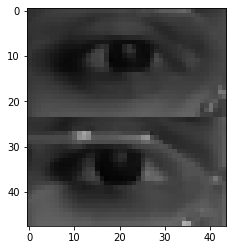

In [ ]:
SAMPLE_NUMBER = 2
print(x2_chs_inp[SAMPLE_NUMBER])
print(y_load[SAMPLE_NUMBER])
plt.imshow(x1_chg_bri[SAMPLE_NUMBER].reshape((frame_height, frame_width)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

In [ ]:
x1_scaler = 255
x1 = x1_chg_bri / x1_scaler

x2_scaler = StandardScaler()
x2 = x2_scaler.fit_transform(x2_chs_inp)

y_scalers = y_load.max(0)
y = y_load / y_scalers

scalers = [x1_scaler, x2_scaler, y_scalers]
jdump(scalers, scaler_dir)

['/content/drive/MyDrive/Projects/EyeTracker/models/eye_tracking/trained/scalers.bin']

In [ ]:
x1_shf, x2_shf, y1_shf, y2_shf = shuffle(x1, x2, y[:, 0], y[:, 1])

n_train = int(R_TRAIN * n_smp)
n_test = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y1_train, y2_train = y1_shf[:n_train], y2_shf[:n_train]
y1_test, y2_test = y1_shf[n_train:], y2_shf[n_train:]

print(x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape,
      x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape)

(20825, 48, 44, 1) (3675, 48, 44, 1) (20825,) (3675,) (20825, 7) (3675, 7) (20825,) (3675,)


In [ ]:
x_train_list = [x1_train, x2_train]
x_test_list = [x1_test, x2_test]

In [ ]:
cb = EarlyStopping(patience=PATIENCE, verbose=1, restore_best_weights=True)

In [ ]:
model1 = load_model(raw_models_dir + MODEL_FOL + "1")
model2 = load_model(raw_models_dir + MODEL_FOL + "2")
print(model1.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 48, 44, 16)   416         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 24, 22, 16)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 24, 22, 32)   12832       max_pooling2d_16[0][0]           
____________________________________________________________________________________________

In [ ]:
results1 = model1.fit(x_train_list,
                      y1_train,
                      validation_data=(x_test_list, y1_test),
                      epochs=N_EPOCHS,
                      callbacks=cb)

In [ ]:
results2 = model2.fit(x_train_list,
                      y2_train,
                      validation_data=(x_test_list, y2_test),
                      epochs=N_EPOCHS,
                      callbacks=cb)

In [ ]:
y1hat_train = model1.predict(x_train_list).reshape((n_train,))
y1hat_test = model1.predict(x_test_list).reshape((n_test,))
y2hat_train = model2.predict(x_train_list).reshape((n_train,))
y2hat_test = model2.predict(x_test_list).reshape((n_test,))

In [ ]:
y1hat_train[y1hat_train < 0] = 0
y2hat_train[y2hat_train < 0] = 0
y1hat_test[y1hat_test < 0] = 0
y2hat_test[y2hat_test < 0] = 0

Train
(599, 0)
(584, 0)
Test
(0, 1896)
(0, 1912)


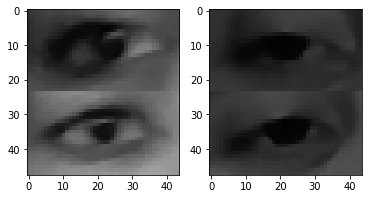

In [ ]:
NUM = 32
print("Train")
sample_train = (int(y1_train[NUM] * y_scalers[0]),
                int(y2_train[NUM] * y_scalers[1]))
sample_train_hat = (int(y1hat_train[NUM] * y_scalers[0]),
                    int(y2hat_train[NUM] * y_scalers[1]))
print(sample_train)
print(sample_train_hat)

print("Test")
sample_test = (int(y1_test[NUM] * y_scalers[0]),
                int(y2_test[NUM] * y_scalers[1]))
sample_test_hat = (int(y1hat_test[NUM] * y_scalers[0]),
                    int(y2hat_test[NUM] * y_scalers[1]))
print(sample_test)
print(sample_test_hat)

_, ax = plt.subplots(1,2)
ax[0].imshow((x1_train[NUM] * x1_scaler).astype(np.uint8).
           reshape((frame_height, frame_width)), cmap="gray",vmin=0, vmax=255)
ax[1].imshow((x1_test[NUM] * x1_scaler).astype(np.uint8).
           reshape((frame_height, frame_width)), cmap="gray",vmin=0, vmax=255)

In [ ]:
print(y1_train.shape)

(20825,)


In [ ]:
# train_loss = np.abs(y_train - yhat_train).sum(0) / n_train
# test_loss = np.abs(y_test - yhat_test).sum(0) / n_test

In [ ]:
model1.save(trained_models_dir + MODEL_FOL + "1")
model2.save(trained_models_dir + MODEL_FOL + "2")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/models/eye_tracking/trained/model21/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/models/eye_tracking/trained/model22/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/models/eye_tracking/trained/model21/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/models/eye_tracking/trained/model22/assets
